# 作業 : (Kaggle)鐵達尼生存預測 
https://www.kaggle.com/c/titanic

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 觀察降低偏態的影響

# [作業重點]
- 觀察使用log1p降偏態時, 對於分布與迴歸分數的影響 (In[6], Out[6])
- 修正區塊中的資料問題後, 觀察以box-cox降偏態, 對於分布與迴歸分數的影響 (In[7], Out[7])

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

data_path = './drive/My Drive/ML_100/day7/'
df_train = pd.read_csv(data_path + 'titanic_train.csv')
df_test = pd.read_csv(data_path + 'titanic_test.csv')

train_Y = df_train['Survived']
ids = df_test['PassengerId']
df_train = df_train.drop(['PassengerId', 'Survived'] , axis=1)
df_test = df_test.drop(['PassengerId'] , axis=1)
df = pd.concat([df_train,df_test])
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [26]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(0)
MMEncoder = MinMaxScaler()
train_num = train_Y.shape[0]
df.head()

5 Numeric Features : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']



,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


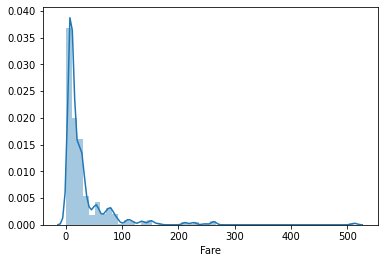

In [27]:
# 顯示 Fare 與目標值的散佈圖
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(df['Fare'][:train_num])
plt.show()

In [28]:
# 計算基礎分數
df_mm = MMEncoder.fit_transform(df)
train_X = df_mm[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.7015378821166279

# 作業1 
* 試著在鐵達尼的票價 (Fare) 欄位中使用對數去偏 (log1p) , 結果是否更好?

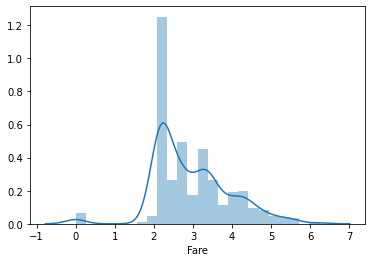

0.710545477371163

In [29]:
# 將 Fare 取 log1p 後, 看散佈圖, 並計算分數
df_fixed = copy.deepcopy(df)
"""
Your Code Here, transform df_fixed['Fare'] with log1p
"""
df_fixed['Fare'] = np.log1p(df_fixed['Fare'])

sns.distplot(df_fixed['Fare'][:train_num])
plt.show()

df_fixed = MMEncoder.fit_transform(df_fixed)
train_X = df_fixed[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

# 作業2
* 最後的 boxcox 區塊直接執行會造成錯誤, 起因為輸入值有負值, 請問如何修正後可以使用 boxcox? (Hint : 試圖修正資料)

In [30]:
df_fixed = copy.deepcopy(df)
df_fixed['Fare']

0        7.2500
1       71.2833
2        7.9250
3       53.1000
4        8.0500
         ...   
413      8.0500
414    108.9000
415      7.2500
416      8.0500
417     22.3583
Name: Fare, Length: 1309, dtype: float64

In [31]:
from scipy import stats
df_fixed['Fare'] = df_fixed['Fare'].clip(0.5 , df_fixed['Fare'].max())
stats.boxcox(df_fixed['Fare'])

(array([1.87980665, 3.81545159, 1.95970015, ..., 1.87980665, 1.97370613,
        2.8630713 ]), -0.053407270063562905)

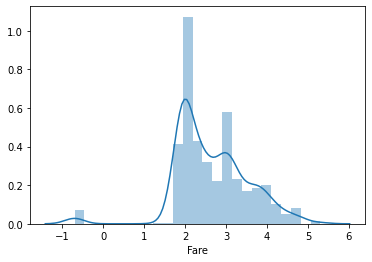

0.710545477371163

In [32]:
# 將 Fare 取 boxcox 後, 看散佈圖, 並計算分數 (執行會有 error, 請試圖修正)
from scipy import stats
df_fixed = copy.deepcopy(df)
"""
Your Code Here, fix the error
"""
#df_fixed[df_fixed['Fare']<0] = df_fixed['Fare'].mean()

df_fixed['Fare'] = df_fixed['Fare'].clip(0.5 , df_fixed['Fare'].max())

# If the lmbda parameter is None, the second returned argument is the lambda that maximizes the log-likelihood function.
# 所以用[0]
df_fixed['Fare'] = stats.boxcox(df_fixed['Fare'])[0]
sns.distplot(df_fixed['Fare'][:train_num])
plt.show()

df_fixed = MMEncoder.fit_transform(df_fixed)
train_X = df_fixed[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

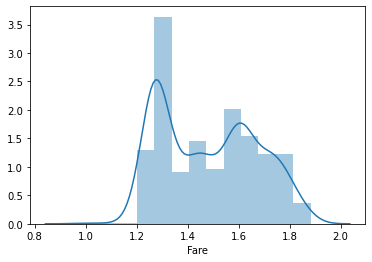

0.6948088632226477

In [33]:
# 將 Fare 取 boxcox 後, 看散佈圖, 並計算分數 (執行會有 error, 請試圖修正)
from scipy import stats
df_fixed = copy.deepcopy(df)
"""
Your Code Here, fix the error
"""
# Note there is 0 in Fare
# https://stackoverflow.com/questions/39612300/pandas-change-values-chosen-by-boolean-indexing-in-a-column-without-getting-a-w
df_fixed.loc[df_fixed['Fare']<=0 , 'Fare'] = df['Fare'].mean()


# If the lmbda parameter is None, the second returned argument is the lambda that maximizes the log-likelihood function.
# 所以用[0]
df_fixed['Fare'] = stats.boxcox(df_fixed['Fare'])[0]
sns.distplot(df_fixed['Fare'][:train_num])
plt.show()

df_fixed = MMEncoder.fit_transform(df_fixed)
train_X = df_fixed[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()